In [1]:
import numpy as np
import matplotlib.pyplot as plt
from readResults import *
import os

In [29]:
def get_results(folder, fname_prefix, nevents, spacing=None, n_div_r=20, seed=None, damage_type='SSB', particle=None, keyword=None):
    
    radii = range(n_div_r)
    fname_base = f"{fname_prefix}"
    if spacing and seed:
        fname_base += f"_{spacing}um_"+f"{seed}"
    if keyword:
        fname_base+=f'_{keyword}'
    if particle: 
        fname_base+=f"_{particle}"

    if damage_type == "SSB":
        fname = fname_base
    elif damage_type == "DSB":
        fname = fname_base+f"_DSB"
    fnames = [os.path.join(folder, fname+f"_{r}.csv") for r in radii]
    
    dataset = {}

    for i, fname in zip(radii, fnames):
        to_combine = []

        to_combine.append(readIN(fname))

        if len(to_combine) != 0:
            dataset[i] = combine(to_combine)

    # plot strand breaks vs LET & energy per dose
    damage_out = {}
    total = np.zeros(n_div_r)
    direct = np.zeros(n_div_r)
    indirect = np.zeros(n_div_r)

    dose_out = np.zeros(n_div_r)
    radii_out = np.zeros(n_div_r)


    for i in radii:
        if damage_type=='SSB':
        #en.append(getEnergy(dataset[i]))
            nSSB, dose, nGBP = calcBreaksperDose("TotalSBtotal", (dataset[i]))
            total[i]=nSSB/nGBP
            nSSB, dose, nGBP = calcBreaksperDose("TotalSBdirect", (dataset[i]))
            direct[i] = nSSB/nGBP
            nSSB, dose, nGBP = calcBreaksperDose("TotalSBindirect", (dataset[i]))
            indirect[i]= nSSB/nGBP
        
        elif damage_type=='DSB':
            nDSB, dose, nGBP = calcSimpleDSBperDose("Total", (dataset[i]))
            total[i] = nDSB/nGBP
            nDSB, dose, nGBP = calcSimpleDSBperDose("Direct", (dataset[i]))
            direct[i] = nDSB/nGBP
            nDSB, dose, nGBP = calcSimpleDSBperDose("Indirect", (dataset[i]))
            indirect[i] = nDSB/nGBP
        if spacing:
            radii_out[i] = 10.5+i*spacing  
        else:
            radii_out[i] = 10.5+i*2
        dose_out[i] = dose if dose else 0

    damage_out['total'] = total
    damage_out['direct'] = direct
    damage_out['indirect'] = indirect
    damage_out['dose'] = dose_out
    damage_out['distance'] = radii_out 

    return damage_out


In [58]:
#DOSE
def plot_dose(damage, spacing=None, fig_ex=None, part=None):
    if fig_ex==None:
        fig = plt.figure(figsize=(8, 5))
        plt.plot(damage['distance'], damage['dose'], color='darkblue', marker='s', markersize=3, linestyle='-', linewidth=.9,
                label=f'Dose')
        
    else:
        fig = fig_ex
        plt.plot(damage['distance'], damage['dose'], marker='s', markersize=3, linestyle='-', linewidth=.9,
                label=f'Dose'+f"_{part}" if part else None)
    
    plt.legend()
    plt.ticklabel_format(axis='y', style='sci',scilimits=(4,4))
    spacing_str = spacing if spacing else 2
    plt.title(f"Dose vs distance, spacing: {spacing_str} um")
    plt.xlabel("Radial distance (um)")
    plt.ylabel('Dose ($Gy$)', fontsize=11)

    return fig

In [36]:
def plot_damage(damage, damage_type, spacing=None, bydose=False, fig_ex=None):
    
    if fig_ex==None:
        fig = plt.figure(figsize=(8, 5))
    else:
        fig=fig_ex

    if bydose:
        
        plt.plot(damage['distance'], np.divide(damage['total'], damage['dose'], out=np.zeros_like(damage['total']),where=damage['dose']!=0), color='k',
                    label=f'Total SB', marker='x', linewidth=.6, markersize=3)
        plt.plot(damage['distance'], np.divide(damage['indirect'], damage['dose'], out=np.zeros_like(damage['indirect']),where=damage['dose']!=0),
                    color='mediumvioletred', label=f'Indirect SB',linewidth=.6, marker='o', markersize=3)
        plt.plot(damage['distance'], np.divide(damage['direct'], damage['dose'], out=np.zeros_like(damage['direct']),where=damage['dose']!=0), color='cornflowerblue',
                label=f'Direct SB', linewidth=.6,  marker='s', markersize=3)
        plt.ylabel(f'Number of {damage_type} ($Gy^{-1} Gbp^{-1}$)', fontsize=11)

    else:
        plt.plot(damage['distance'], damage['total'], color='k',
                    label=f'Total SB', marker='x', linewidth=.6, markersize=3)
        plt.plot(damage['distance'], damage['indirect'],
                    color='mediumvioletred', label=f'Indirect SB',linewidth=.6, marker='o', markersize=3)
        plt.plot(damage['distance'], damage['direct'], color='cornflowerblue',
                label=f'Direct SB', linewidth=.6,  marker='s', markersize=3)
        plt.ylabel(f'Number of {damage_type} ($Gbp^{-1}$)', fontsize=11)
   
    plt.legend()
    spacing_str = spacing if spacing else 2
    plt.title(f"DNA damage vs distance, spacing: {spacing_str} um")
    plt.xlabel("Radial distance (um)")

    return fig

In [37]:
def plot_damage_multipart(damage, damage_type, particle_list, spacing = None, bydose=False, fig_ex=None):
    
    if fig_ex==None:
        fig = plt.figure(figsize=(8, 5))
    else:
        fig=fig_ex
    colors = ['k', 'mediumvioletred', 'cornflowerblue']
   # markers = ['x', 'o', 's']
    for part, c in zip(particle_list, colors):
        damage_part = damage[part]
        if bydose:
            
            plt.plot(damage_part['distance'], np.divide(damage_part['total'], damage_part['dose'], out=np.zeros_like(damage_part['total']),where=damage_part['dose']!=0), color=c,
                        label=f'Total {damage_type}_{part}', marker='x', linewidth=.5, markersize=3)
            plt.plot(damage_part['distance'], np.divide(damage_part['indirect'], damage_part['dose'], out=np.zeros_like(damage_part['indirect']),where=damage_part['dose']!=0),
                        color=c, label=f'Indirect {damage_type}_{part}',linewidth=.5, marker='o', markersize=3)
            plt.plot(damage_part['distance'], np.divide(damage_part['direct'], damage_part['dose'], out=np.zeros_like(damage_part['direct']),where=damage_part['dose']!=0), color=c,
                    label=f'Direct_{damage_type}_{part}', linewidth=.6,  marker='s', markersize=3)
            plt.ylabel('Number of {damage_type} ($Gy^{-1} Gbp^{-1}$)', fontsize=11)

        else:
            plt.plot(damage_part['distance'], damage_part['total'], color=c,
                        label=f'Total SB {part}', marker='x', linewidth=.5, markersize=3)
            plt.plot(damage_part['distance'], damage_part['indirect'],
                        color=c, label=f'Indirect SB  {part}',linewidth=.5, marker='o', markersize=3)
            plt.plot(damage_part['distance'], damage_part['direct'], color=c,
                    label=f'Direct SB  {part}', linewidth=.6,  marker='s', markersize=3)
            plt.ylabel(f'Number of {damage_type} ($Gbp^{-1}$)', fontsize=11)
   
    plt.legend()
    spacing_str = spacing if spacing else 2
    plt.title(f"DNA damage_part vs distance, spacing: {spacing_str} um")
    plt.xlabel("Radial distance (um)")

    return fig

In [38]:
def plot_results(damage, fname_prefix, out_folder = "./",damage_type= 'SSB', seed=1, savefig=False, spacing=2, particle=None ):
    
    # not dividing by dose
    fig_abs = plot_damage(damage, damage_type, spacing, bydose=False)
    if savefig:
        plt.savefig(os.path.join(out_folder, f"{damage_type}"+(f"_{particle}" if particle else None)+f"_abs_{fname_prefix}_{spacing}um_{seed}.png"), fig=fig_abs)
    else:
        plt.show()

    # Dividing by dose
    fig_bydose = plot_damage(damage, damage_type, spacing, bydose=True)
    if savefig:
        plt.savefig(os.path.join(out_folder, f"{damage_type}"+(f"_{particle}" if particle else None)+f"_byDose_{fname_prefix}_{spacing}um_{seed}.png"), fig=fig_bydose)
    else:
        plt.show()

    #DOSE

    fig_dose =plot_dose(damage, spacing)
    if savefig:
        plt.savefig(os.path.join(out_folder, f"dose_{damage_type}"+(f"_{particle}" if particle else None)+f"_{fname_prefix}_{spacing}um_{seed}.png"), fig=fig_dose)
    else:
        plt.show()

    return fig_abs, fig_bydose, fig_dose

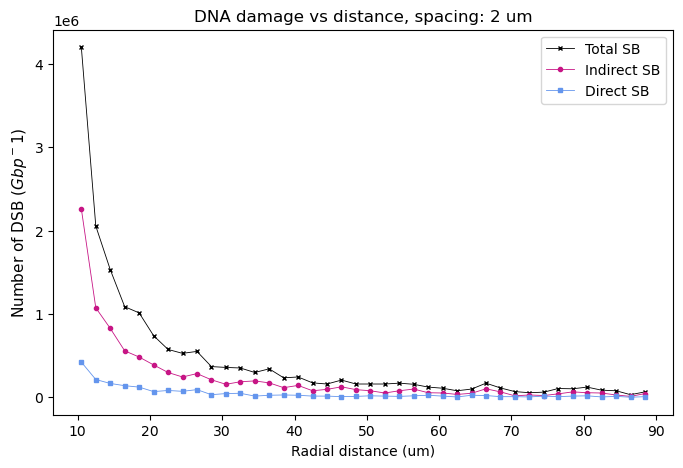

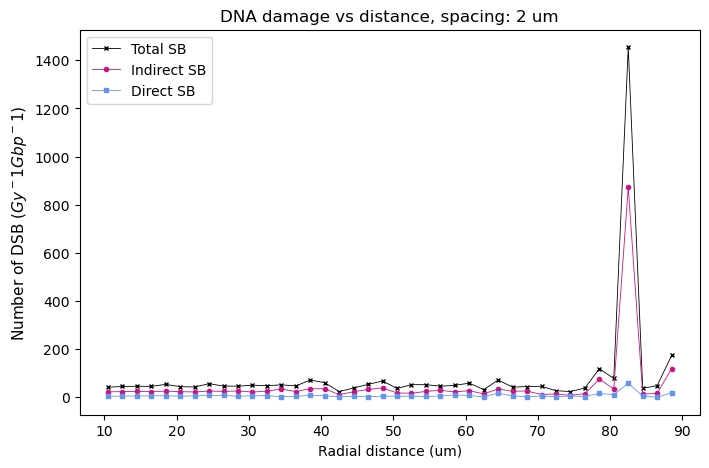

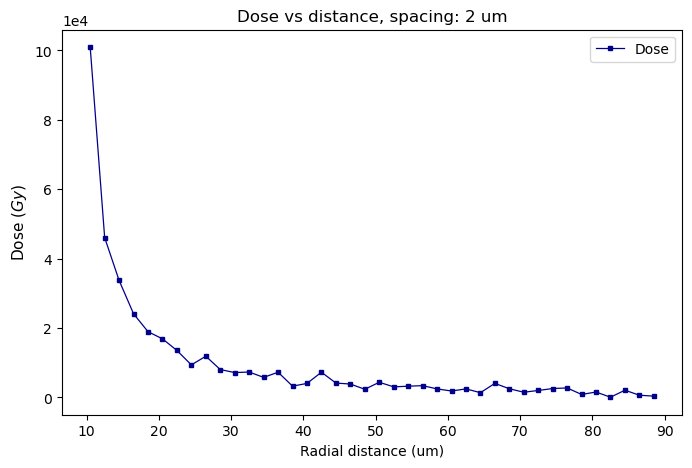

In [59]:
for part in ['alpha']:
    damage = get_results(fname_prefix = "out_AtDNA_10k_spacing", nevents=10000, 
                         folder = "output/test_At10k_160k_boxes_10.5um/clustering_out/",
                                                  spacing=2, n_div_r=40, seed=202,
                                                  damage_type='DSB', particle=part, keyword = "up")
    plot_results(damage, fname_prefix="out_AtDNA_10k_spacing", damage_type='DSB', seed=202)

In [60]:
damage = {}
for part in ['alpha', 'e-']:
    damage[part] = get_results(fname_prefix = "out_AtDNA_10k_spacing", nevents=10000, 
                               folder = "output/test_At10k_160k_boxes_10.5um/clustering_out",
                                                  spacing=2, n_div_r=40, seed=1144, keyword = 'up',
                                                  damage_type='SSB', particle=part)

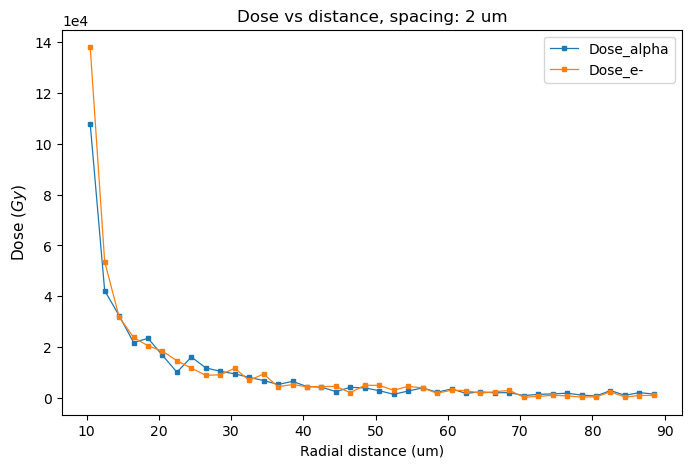

In [61]:
fig = plt.figure(figsize=(8,5))
for part in ['alpha', 'e-']:
    plot_dose(damage[part], spacing=2, fig_ex=fig, part=part)
plt.show()

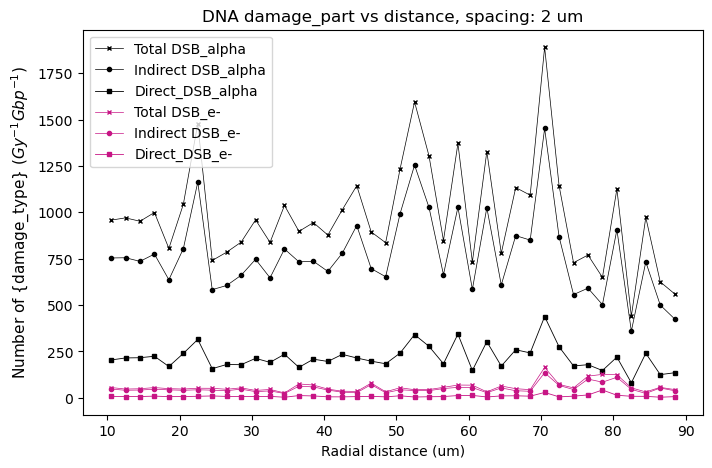

In [62]:
plot_damage_multipart(damage, damage_type="DSB", spacing=2, particle_list=['alpha', 'e-'], bydose=True)
plt.show()

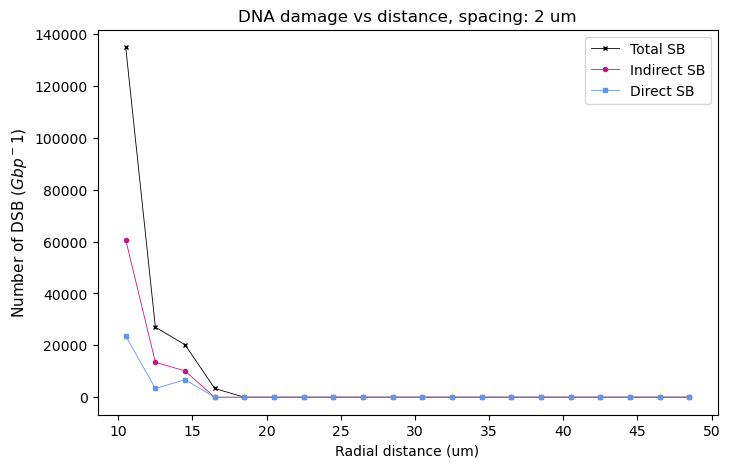

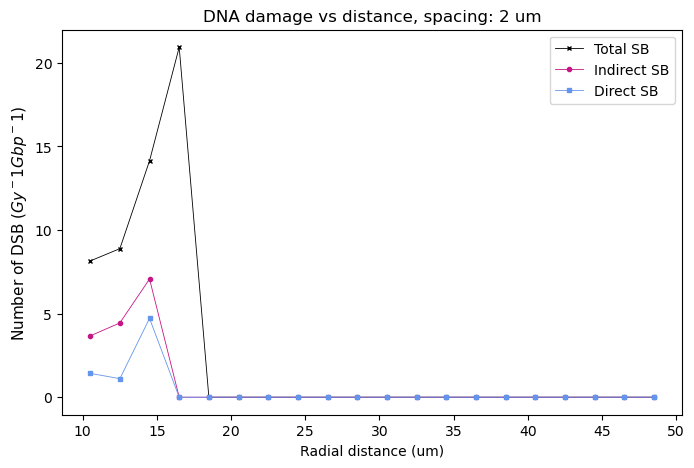

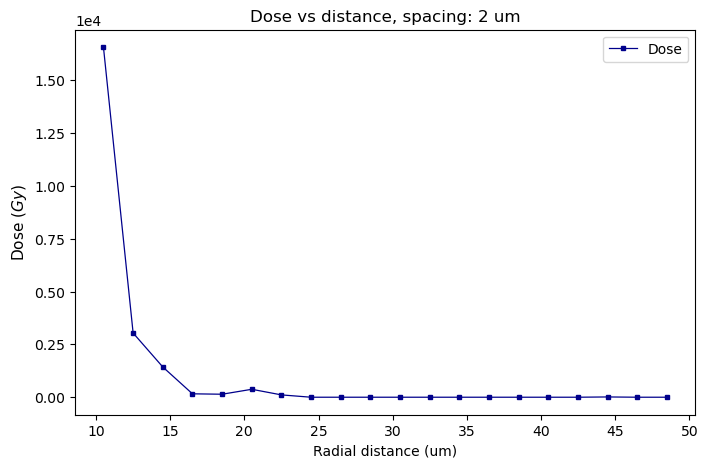

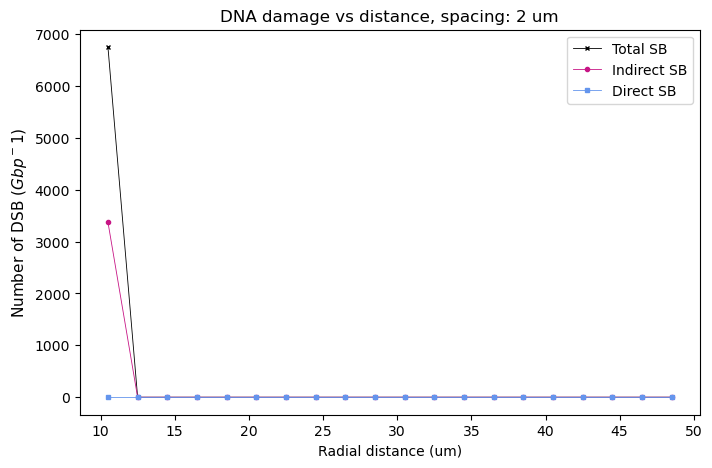

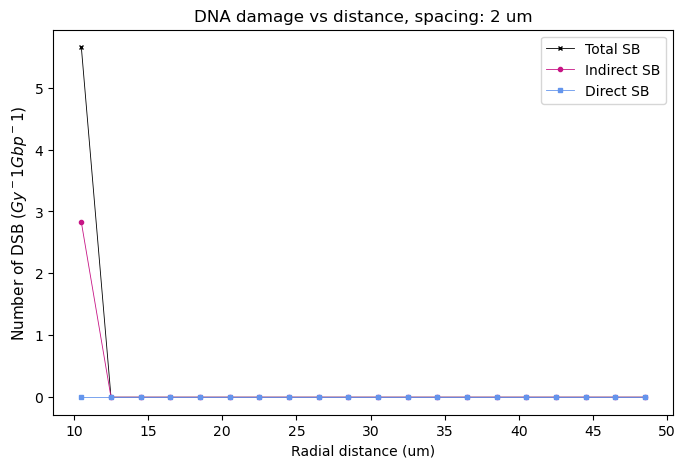

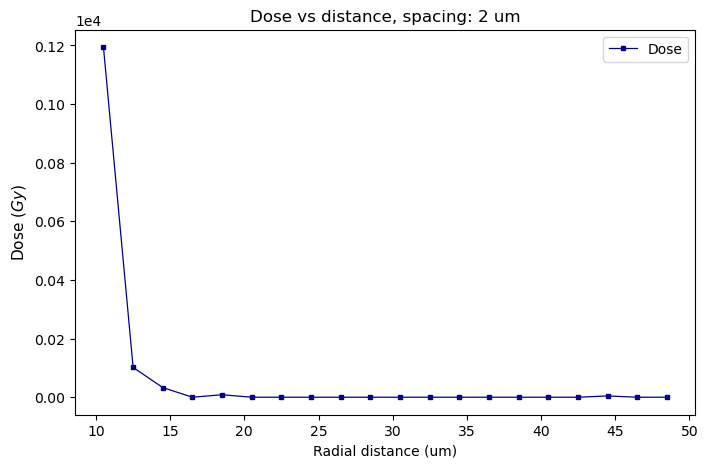

FileNotFoundError: [Errno 2] No such file or directory: './output/test_plot_At1k/test_plot_At1k_mup_gamma_DSB_0.csv'

In [64]:
for part in ['alpha', 'e-', 'gamma']:
    damage = get_results(fname_prefix = "test_plot_At1k", nevents=1000, folder = "./output/test_plot_At1k/",
                                                n_div_r=20, damage_type='DSB', particle=part, keyword='mup')
    plot_results(damage, fname_prefix="test_plot_At1k", damage_type='DSB')

In [67]:
damage = {}
for part in ['alpha', 'e-']:
    damage[part] = get_results(fname_prefix = "test_plot_At1k", nevents=1000, folder = "./output/test_plot_At1k",
                                                  n_div_r=20, keyword='mup',
                                                  damage_type='DSB', particle=part)

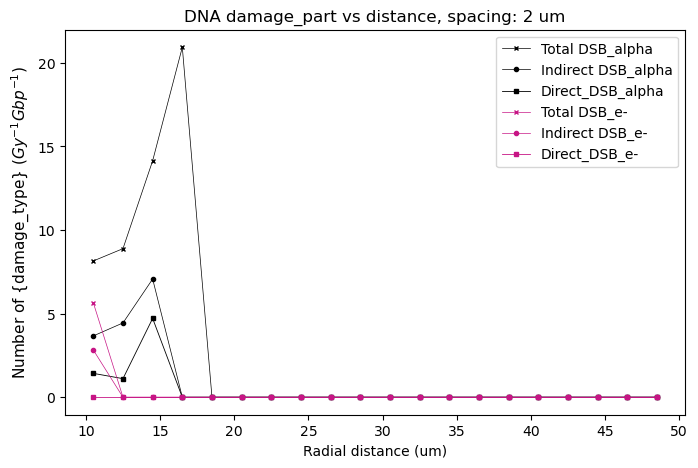

In [70]:
plot_damage_multipart(damage, damage_type="DSB", spacing=2, particle_list=['alpha', 'e-'], bydose=True)
plt.show()

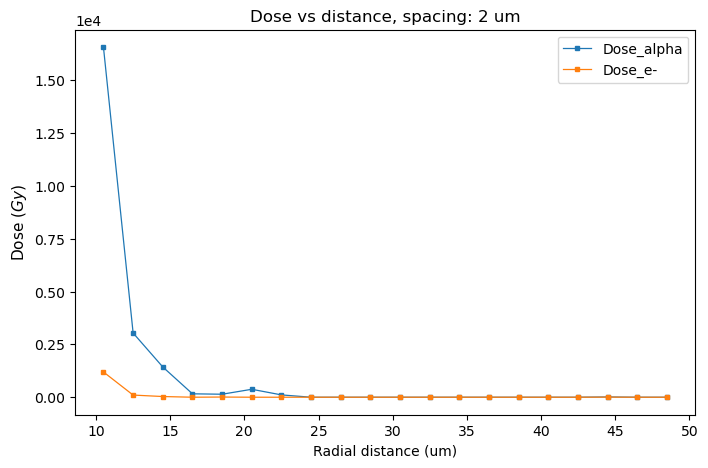

In [71]:
fig = plt.figure(figsize=(8,5))
for part in ['alpha', 'e-']:
    plot_dose(damage[part], spacing=2, fig_ex=fig, part=part)
plt.show()

In [14]:
damage = {}
for part in ['alpha', 'e-', 'gamma']:
    damage[part] = get_results(fname_prefix = "out_AtDNA_10k_spacing", nevents=10000, 
                         folder = "output/test_At10k_160k_boxes_10.5um/clustering_out_NEW/",
                                                  spacing=2, n_div_r=40, seed=1144,
                                                  damage_type='SSB', particle=part, keyword = "mup")

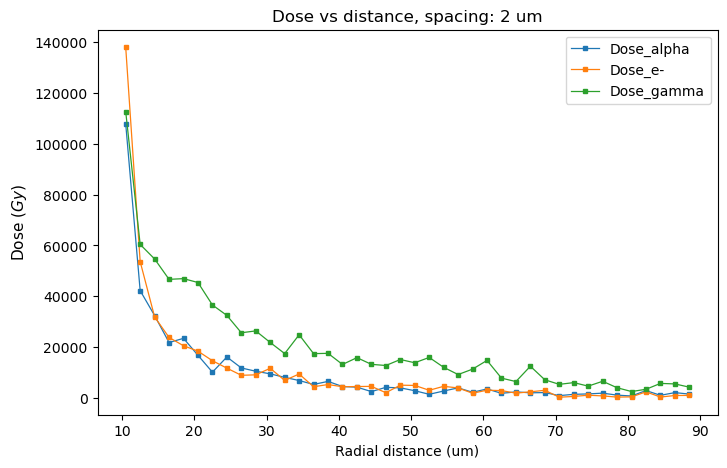

In [15]:
fig = plt.figure(figsize=(8,5))
for part in ['alpha', 'e-', 'gamma']:
    plot_dose(damage[part], spacing=2, fig_ex=fig, part=part)
plt.show()

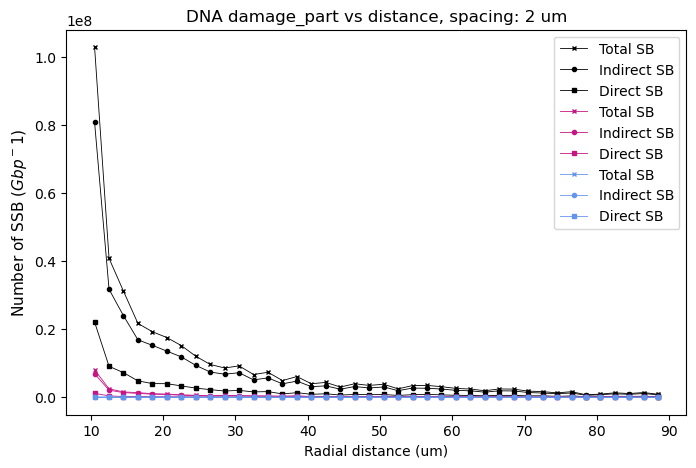

In [16]:
plot_damage_multipart(damage, damage_type="SSB", spacing=2, particle_list=['alpha', 'e-', 'gamma'])
plt.show()

In [74]:
damage = {}
for part in ['alpha', 'e-']:
    damage[part] = get_results(fname_prefix = "out_AtDNA_10k_spacing", nevents=10000, 
                         folder = "output/test_At10k_160k_boxes_10.5um/clustering_out/",
                                                  spacing=2, n_div_r=40, seed=1144,
                                                  damage_type='DSB', particle=part, keyword = "up")

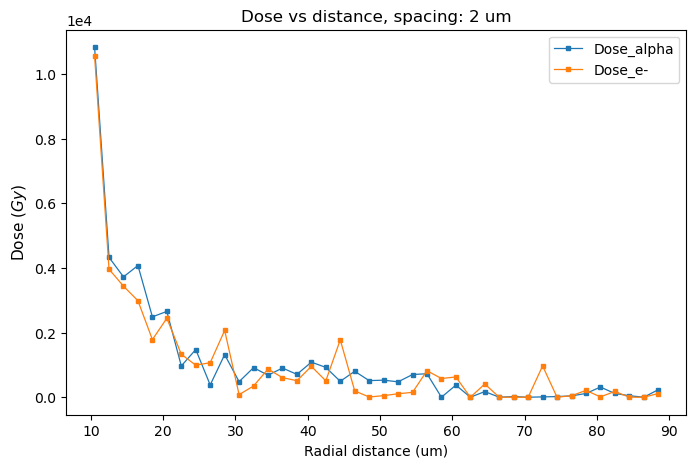

In [76]:
fig = plt.figure(figsize=(8,5))
for part in ['alpha', 'e-']:
    plot_dose(damage[part], spacing=2, fig_ex=fig, part=part)
plt.show()

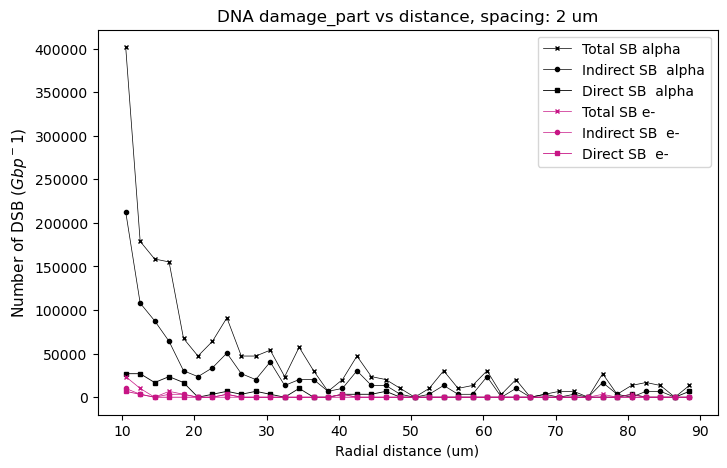

In [78]:
plot_damage_multipart(damage, damage_type="DSB", spacing=2, particle_list=['alpha', 'e-'])
plt.show()